In [9]:

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score
import mlrose_hiive as mlrose
import time
from typing import Any
import matplotlib.pyplot as plt
import glob


In [3]:
RANDOM_SEED=42
IMAGE_SIZE=(64,64)
COLORS = {
    "kNN": 'red',
    'SVM': 'blue',
    'NN': 'green'
}
DATASET_NAME = "bank-marketing"

In [5]:
df = pd.read_csv("bank/bank-full.csv",delimiter=';')

# Convert numerical columns to the correct data type
df["age"] = df["age"].astype(int)
df["balance"] = df["balance"].astype(int)
df["day"] = df["day"].astype(int)
df["duration"] = df["duration"].astype(int)
df["campaign"] = df["campaign"].astype(int)
df["pdays"] = df["pdays"].astype(int)
df["previous"] = df["previous"].astype(int)
df["y"] = [0 if y=="no" else 1 for y in df["y"]]

# Separate features and target
X = df.drop(columns=["y"])
y = df["y"]

# Define which columns are numerical and which are categorical
numerical_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Create a preprocessing and modeling pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

# Fit and transform the data
X_preprocessed = pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=RANDOM_SEED)

In [8]:

models = [
    ('genetic_alg_queens', mlrose.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        learning_rate=0.001,
        algorithm='genetic_alg',
        is_classifier=True,
        mutation_prob= 0.1,
        pop_size=100,
    )),
    ('genetic_alg_four_peaks', mlrose.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        learning_rate=0.001,
        algorithm='genetic_alg',
        mutation_prob= 0.4,
        pop_size=400,
        is_classifier=True
    )),
    ('simulated_annealing_queens', mlrose.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        learning_rate=0.001,
        algorithm='simulated_annealing',
        schedule=mlrose.ExpDecay(init_temp=0.7, exp_const=0.004, min_temp=0.001),
        is_classifier=True
    )),
    ('simulated_annealing_four_peaks', mlrose.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        learning_rate=0.001,
        algorithm='simulated_annealing',
        schedule=mlrose.ArithDecay(init_temp=0.9, decay=0.003, min_temp=0.001),
        is_classifier=True
    )),
    ('backprop', mlrose.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        learning_rate=0.001,
        is_classifier=True
    )),
    ('random_hill_climbing_queens', mlrose.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        learning_rate=0.001,
        algorithm='random_hill_climb',
        max_attempts=20,
        is_classifier=True
    )),
    ('random_hill_climbing_four_peaks', mlrose.NeuralNetwork(
        hidden_nodes=[128],
        activation='relu',
        learning_rate=0.001,
        algorithm='random_hill_climb',
        max_attempts=10,
        is_classifier=True
    )),
]

# Uncomment for backprop model, replace algorithm = 'backprop', change while statement to while max_iters <= 100
# models = [
#     ("backprop", MLPClassifier(alpha=0.001, beta_1=0.95, hidden_layer_sizes=(128), momentum=0.9))
# ]

def train_neural_networks(nn_list, X_train, y_train, X_test, y_test):
    results = []
    
    for name, nn in nn_list:
        algorithm = nn.algorithm
        max_iters = 1
        step = 1 if algorithm in {'genetic_alg','backprop'} else 50
        max_improvements = {
            "random_hill_climb": 1000,
            'simulated_annealing': 1000,
            'genetic_alg': 5,
            'backprop': 20
        }
        
        while max_iters < max_improvements[algorithm]:
            start_time = time.time()
            nn.set_params(max_iters=max_iters)
            nn.fit(X_train, y_train)
            end_time = time.time()
            
            training_time = end_time - start_time
            
            y_pred = nn.predict(X_test)
            current_f1_score = f1_score(y_test, y_pred, average='weighted')
            
            prev_f1_score = current_f1_score
            
            results.append({
                'algorithm': name,
                'max_iters': max_iters,
                'training_time': training_time,
                'f1_score': current_f1_score
            })
            
            max_iters += step
            print(f"name={name}, algo={algorithm}, f1_score={current_f1_score}, training_time={training_time}, max_iters={max_iters}")
    
    return results

results = train_neural_networks(models, X_train, y_train, X_test, y_test)
pd.DataFrame(results).to_csv(f"nn_comparison_{time.time()}.csv")

name=genetic_alg_queens, algo=genetic_alg, f1_score=0.827214965557116, training_time=15.70787501335144, max_iters=2
name=genetic_alg_queens, algo=genetic_alg, f1_score=0.8229037448063268, training_time=22.153138160705566, max_iters=3
name=genetic_alg_queens, algo=genetic_alg, f1_score=0.8234421185876922, training_time=28.882925987243652, max_iters=4
name=genetic_alg_queens, algo=genetic_alg, f1_score=0.8256162165317447, training_time=36.80382823944092, max_iters=5
name=genetic_alg_four_peaks, algo=genetic_alg, f1_score=0.8343260661503543, training_time=59.112738847732544, max_iters=2
name=genetic_alg_four_peaks, algo=genetic_alg, f1_score=0.8301943528901603, training_time=87.71503281593323, max_iters=3
name=genetic_alg_four_peaks, algo=genetic_alg, f1_score=0.8566055417553269, training_time=124.00170397758484, max_iters=4
name=genetic_alg_four_peaks, algo=genetic_alg, f1_score=0.8276910610725411, training_time=152.49910020828247, max_iters=5


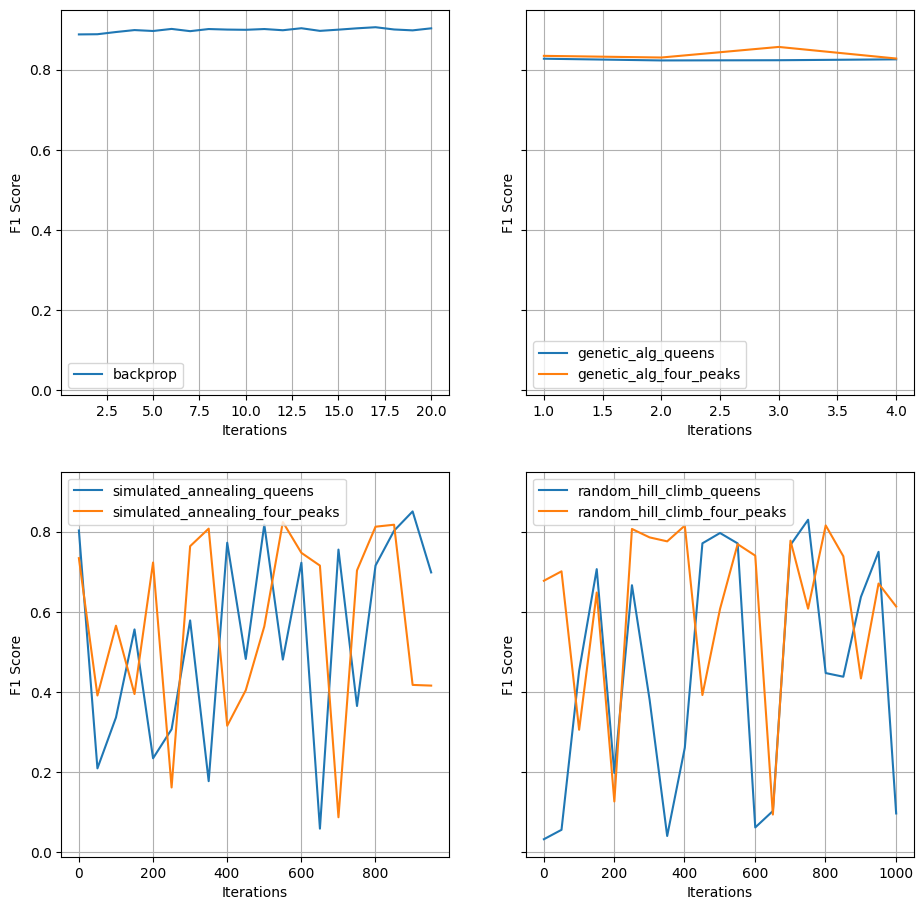

In [18]:
files = glob.glob('nn_comparison_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)

fig, axes = plt.subplots(2, 2, figsize=(11, 11), sharey=True)

# Function to plot subsets
def plot_subset(df, keyword, ax):
    subset = df[df["algorithm"].str.contains(keyword)]
    for algorithm in subset["algorithm"].unique():
        algo_subset = subset[subset["algorithm"] == algorithm]
        ax.plot(algo_subset["max_iters"], algo_subset["f1_score"], label=algorithm)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("F1 Score")
    ax.legend()
    ax.grid(True)

# Plotting each subset
plot_subset(result_df, "backprop", axes[0, 0])
plot_subset(result_df, "genetic_alg", axes[0, 1])
plot_subset(result_df, "simulated_annealing", axes[1, 0])
plot_subset(result_df, "random_hill_climb", axes[1, 1])

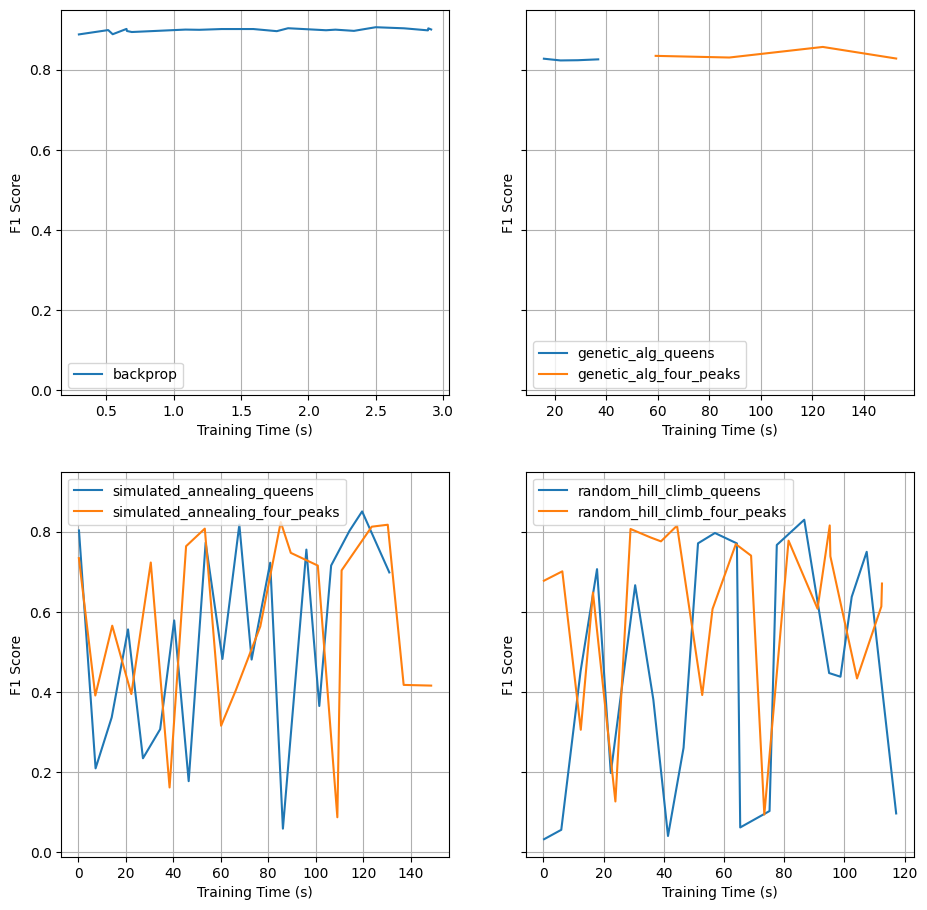

In [21]:
files = glob.glob('nn_comparison_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
result_df = pd.read_csv(latest_file)

fig, axes = plt.subplots(2, 2, figsize=(11, 11), sharey=True)

# Function to plot subsets
def plot_subset(df, keyword, ax):
    subset = df[df["algorithm"].str.contains(keyword)]
    for algorithm in subset["algorithm"].unique():
        algo_subset = subset[subset["algorithm"] == algorithm].sort_values(by="training_time")
        ax.plot(algo_subset["training_time"], algo_subset["f1_score"], label=algorithm)
    ax.set_xlabel("Training Time (s)")
    ax.set_ylabel("F1 Score")
    ax.legend()
    ax.grid(True)

# Plotting each subset
plot_subset(result_df, "backprop", axes[0, 0])
plot_subset(result_df, "genetic_alg", axes[0, 1])
plot_subset(result_df, "simulated_annealing", axes[1, 0])
plot_subset(result_df, "random_hill_climb", axes[1, 1])